In [1]:
import numpy as np
import tensorflow as tf
import csv
import cv2
import os
import random
import pickle
from keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [3]:
import csv
import cv2
import random

all_steering_angles, subsampled_steering_angles, lines = [], [], []
nr_samples = 0

with open("./data/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # ignore first line which contains the headers
    for line in reader:
        nr_samples += 1
        steering_angle = float(line[3])
        all_steering_angles.append(steering_angle)
        if abs(steering_angle) > 0.0 or random.random() > 0.95:
            subsampled_steering_angles.append(steering_angle)
            lines.append(line)

from sklearn.model_selection import train_test_split
train_lines, validation_lines = train_test_split(lines, test_size=0.2)

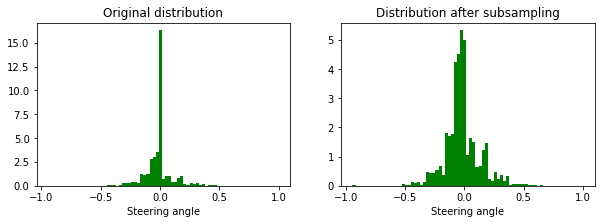

In [4]:
plt.figure(figsize=(10, 3))
ax1 = plt.subplot(1, 2, 1)
ax1.set_title("Original distribution")
plt.hist(np.array(all_steering_angles), 75, normed=1, facecolor='green') [2]
plt.xlabel('Steering angle')
ax2 = plt.subplot(1, 2, 2)
ax2.set_title("Distribution after subsampling")
plt.hist(np.array(subsampled_steering_angles), 75, normed=1, facecolor='green') [2]
plt.xlabel('Steering angle')
plt.show()

In [5]:
print("Total number of samples in csvfile: {0}; number of samples retained: {1}".format(nr_samples, len(lines)))
print("{0} samples in training dataset and {1} in validation dataset".format(len(train_lines), len(validation_lines)))

Total number of samples in csvfile: 12585; number of samples retained: 8358
6686 samples in training dataset and 1672 in validation dataset


In [21]:
def get_path(line_entry):
    return(os.path.join("./data/IMG/", os.path.basename(line_entry.strip())))

def show_image_by_index(idx):
    line = lines[idx]
    source_path = get_path(line[0])
    steering_angle = float(line[3])
    image = cv2.imread(source_path)
    plt.title("Steering angle:\n" + str(steering_angle))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

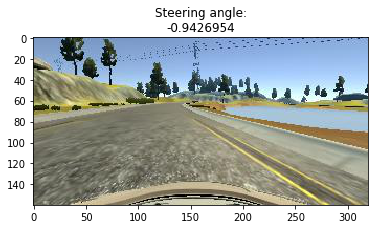

In [26]:
min_index = subsampled_steering_angles.index(min(subsampled_steering_angles))
max_index = subsampled_steering_angles.index(max(subsampled_steering_angles))
show_image_by_index(min_index)

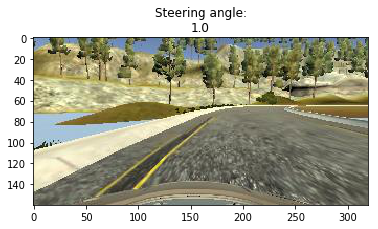

In [25]:
show_image_by_index(max_index)

In [6]:
training_steering_angles, validation_steering_angles = [], []
for line in validation_lines:
    validation_steering_angles.append(float(line[3]))
for line in train_lines:
    training_steering_angles.append(float(line[3]))

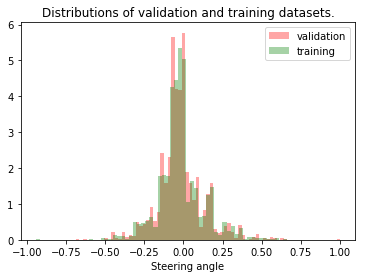

In [7]:
plt.hist(np.array(validation_steering_angles), 75, normed=1, facecolor='red', alpha=0.35, label='validation') [2]
plt.hist(np.array(training_steering_angles), 75, normed=1, facecolor='green', alpha=0.35, label='training') [2]

plt.xlabel('Steering angle')
plt.legend(loc='upper right')
plt.title("Distributions of validation and training datasets.")
plt.show()

In [9]:
def get_augmented_row(line, flipped, angle_idx):
    source_path = get_path(line[angle_idx])
    image = cv2.imread(source_path)
    steering_angle = float(line[3])

    # Add steering angle adjustment to left/right cameras
    if (angle_idx == 0):  # center camera
        steering_angle_corrected = steering_angle
    elif (angle_idx == 1):  # left camera
        steering_angle_corrected = steering_angle + 0.15
    elif (angle_idx == 2):  # right camera
        steering_angle_corrected = steering_angle - 0.15

    if flipped:
        steering_angle_corrected *= -1
        image = np.fliplr(image)

    return image.astype(np.float32), steering_angle_corrected

def get_data_generator(csv_data, batch_size=128, samples_per_epoch=None):
    if samples_per_epoch is None:
        samples_per_epoch = len(csv_data)

    batches_per_epoch = samples_per_epoch // batch_size
    batch_nr = 0

    while True:
        start_idx = batch_nr * batch_size
        end_idx = start_idx + batch_size - 1

        # initialize batch data
        X_batch = np.zeros((batch_size, 160, 320, 3), dtype=np.float32)
        y_batch = np.zeros((batch_size,), dtype=np.float32)

        # slice a `batch_size` sized chunk from the csv_data
        # and generate augmented data for each row in the chunk on the fly
        for idx, csv_line in enumerate(csv_data[start_idx:(end_idx+1)]):
            # perform image augmentation for each row with a random draw for camera and mirroring
            flipped = random.randint(0, 1) == 0
            angle_idx = random.randint(0, 2)

            X, y = get_augmented_row(csv_line, flipped, angle_idx)
            X_batch[idx], y_batch[idx] = X, y

        batch_nr += 1
        if batch_nr == batches_per_epoch - 1:
            # reset the index so that we can cycle over the csv_data again
            batch_nr = 0
        yield X_batch, y_batch

<a list of 100 Patch objects>

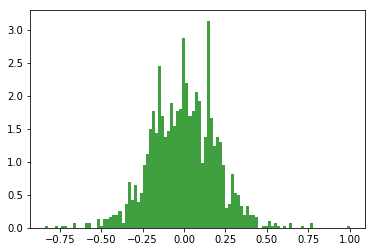

In [10]:
batch_size = 128
samples_per_epoch = (len(validation_lines) // batch_size) * batch_size

line_gen = get_data_generator(validation_lines, batch_size=batch_size, samples_per_epoch=samples_per_epoch)
steering_angles = np.zeros((samples_per_epoch), dtype=np.float64)
for i in range(samples_per_epoch // batch_size):
    X_data, y_data = next(line_gen)
    steering_angles[(i * batch_size):((i+1)* batch_size)] = y_data
plt.hist(steering_angles, 100, normed=1, facecolor='green', alpha=0.75) [2]

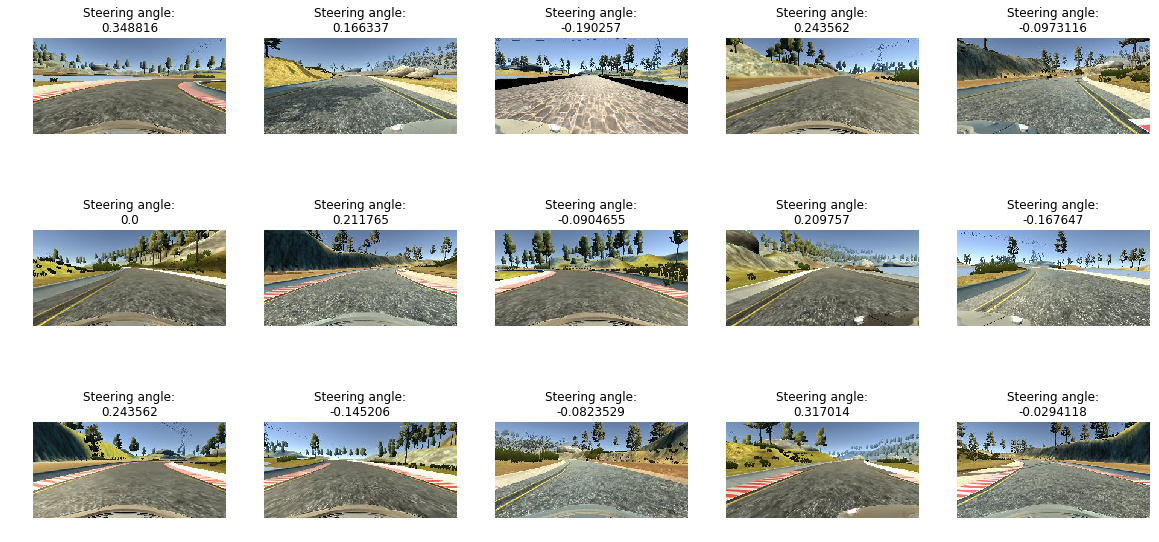

In [11]:
def show_images(nr_images):
    plt_fig = plt.figure(figsize=(20,10))
    indices = random.randint
    for img_nr in range(nr_images):
        img_index = random.randint(0, batch_size - 1)
        sub_plot = plt_fig.add_subplot(3, 5, (img_nr + 1))
        sub_plot.set_title("Steering angle:\n" + str(y_data[img_index]))
        sub_plot.axis('off')
        plt.imshow(cv2.cvtColor(X_data[img_index].astype(np.uint8), cv2.COLOR_BGR2RGB))

show_images(15)

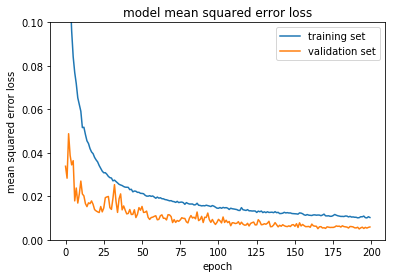

In [12]:
with open('history_object', 'rb') as handle:
    history = pickle.load(handle)
    
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
axes = plt.gca()
axes.set_ylim([0, 0.1])
plt.show()

In [13]:
batch_size = 128
val_samples_per_epoch = (len(validation_lines) // batch_size) * batch_size * 2

validation_generator = get_data_generator(validation_lines,
                                          batch_size=batch_size,
                                          samples_per_epoch=val_samples_per_epoch)

model = load_model("model.h5")

predictions = np.zeros((val_samples_per_epoch), dtype=np.float64)
actuals = np.zeros((val_samples_per_epoch), dtype=np.float64)

for i in range(val_samples_per_epoch // batch_size):
    batch_X_data, batch_y_data = next(line_gen)
    batch_predictions = model.predict(batch_X_data)
    predictions[(i * batch_size):((i+1)* batch_size)] = batch_predictions[:,0]
    actuals[(i * batch_size):((i+1)* batch_size)] = batch_y_data

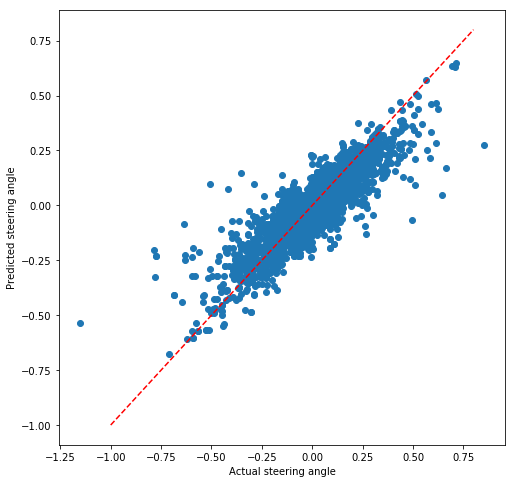

In [14]:
plt.figure(figsize=(8, 8))
plt.scatter(x=actuals, y=predictions)
plt.xlabel("Actual steering angle")
plt.ylabel("Predicted steering angle")
plt.plot([-1, 0.8], [-1, 0.8], "r--")

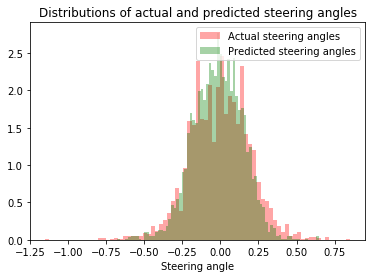

In [15]:
plt.hist(np.array(actuals), 75, normed=1, facecolor='red', alpha=0.35, label='Actual steering angles') [2]
plt.hist(np.array(predictions), 75, normed=1, facecolor='green', alpha=0.35, label='Predicted steering angles') [2]

plt.xlabel('Steering angle')
plt.legend(loc='upper right')
plt.title("Distributions of actual and predicted steering angles")
plt.show()